In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


In [4]:
import sys
sys.path.append('../scripts')

In [5]:
from experience_analytics import analyze_customer_experience
from aggregiate_metrics import aggregate_user_metrics
from satistfaction_anlysis import SatisfactionAnalyzer
from load_data import export_to_db,load_data


### Get data

In [6]:
# Get engagement and experience data
engagement_data = aggregate_user_metrics()
experience_results = analyze_customer_experience()
experience_data = experience_results['processed_data']

Connected to the database


c:\Users\Kalea\Desktop\week-2\notebooks\../scripts\load_data.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(query, conn)


Data loaded successfully
Database connection closed
Connected to the database


c:\Users\Kalea\Desktop\week-2\notebooks\../scripts\load_data.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(query, conn)


Data loaded successfully
Database connection closed


c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [7]:
# Initialize analyzer
analyzer = SatisfactionAnalyzer()

### Data analysis

In [8]:
print("Engagement Data Shape:", engagement_data.shape)
print("Experience Data Shape:", experience_data.shape)
# Get common users between both datasets
common_users = set(engagement_data['msisdn']).intersection(set(experience_data['msisdn']))
print("\nNumber of common users:", len(common_users))
engagement_data = engagement_data[engagement_data['msisdn'].isin(common_users)]
experience_data = experience_data[experience_data['msisdn'].isin(common_users)]

Engagement Data Shape: (106857, 12)
Experience Data Shape: (106857, 7)

Number of common users: 106856


### Calculate scores

In [9]:
# Calculate scores
engagement_scores = analyzer.calculate_engagement_score(
    engagement_data, 
    None ) # None is used because we are using the internal kmeans model
experience_scores = analyzer.calculate_experience_score(
    experience_data,
    None ) # None is used because we are using the internal kmeans model

c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [10]:
# Calculate satisfaction scores
satisfaction_scores = analyzer.calculate_satisfaction_score(engagement_scores, experience_scores)

In [11]:
# Create results dataframe
results_df = pd.DataFrame({
    'msisdn': experience_data['msisdn'],
    'engagement_score': engagement_scores,
    'experience_score': experience_scores,
    'satisfaction_score': satisfaction_scores
})

### Data visualization 

In [12]:
# Display top 10 most satisfied customers
print("\nTop 10 Most Satisfied Customers:")
print(results_df.nlargest(10, 'satisfaction_score')[
    ['msisdn', 'engagement_score', 'experience_score', 'satisfaction_score']
])


Top 10 Most Satisfied Customers:
             msisdn  engagement_score  experience_score  satisfaction_score
13180  3.362578e+10          1.000000          0.583185            0.791592
13526  3.362632e+10          0.528081          0.609037            0.568559
6437   3.361489e+10          0.583062          0.549163            0.566112
28304  3.365217e+10          0.027595          0.998362            0.512978
96064  3.376171e+10          0.025217          1.000000            0.512608
37490  3.365983e+10          0.027547          0.996728            0.512138
76265  3.367567e+10          0.023547          0.991857            0.507702
56811  3.366459e+10          0.019103          0.991857            0.505480
45158  3.366168e+10          0.025002          0.985433            0.505218
29479  3.365811e+10          0.020966          0.988635            0.504801


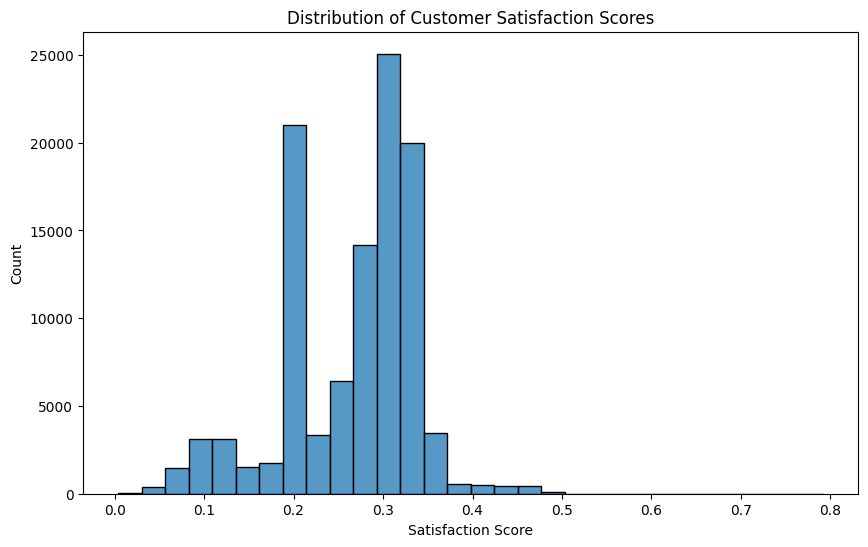

In [13]:
# Visualize the distribution of satisfaction scores
plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='satisfaction_score', bins=30)
plt.title('Distribution of Customer Satisfaction Scores')
plt.xlabel('Satisfaction Score')
plt.ylabel('Count')
plt.show()

In [14]:
# Show basic statistics of the scores
print("\nSatisfaction Score Statistics:")
print(results_df['satisfaction_score'].describe())
### Data modeling


Satisfaction Score Statistics:
count    106856.000000
mean          0.265331
std           0.073086
min           0.004237
25%           0.201860
50%           0.289194
75%           0.318093
max           0.791592
Name: satisfaction_score, dtype: float64


### prepare data for modeling

In [15]:
X = pd.concat([
    engagement_data[['session_count', 'total_duration', 'total_dl', 'total_ul']],
    experience_data[['tcp_retrans_rate', 'avg_rtt', 'avg_throughput']]
], axis=1)
y = satisfaction_scores

In [16]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Model building

In [17]:
# Build and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [18]:
# Make predictions
y_pred = model.predict(X_test)

### Model evaluation

In [19]:
# Calculate performance metrics
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")


Model Performance:
Mean Squared Error: 0.0000
R² Score: 0.9989


In [20]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
            feature  importance
5           avg_rtt    0.786811
4  tcp_retrans_rate    0.151417
6    avg_throughput    0.055579
0     session_count    0.001887
1    total_duration    0.001756
3          total_ul    0.001506
2          total_dl    0.001043


### Model visualization

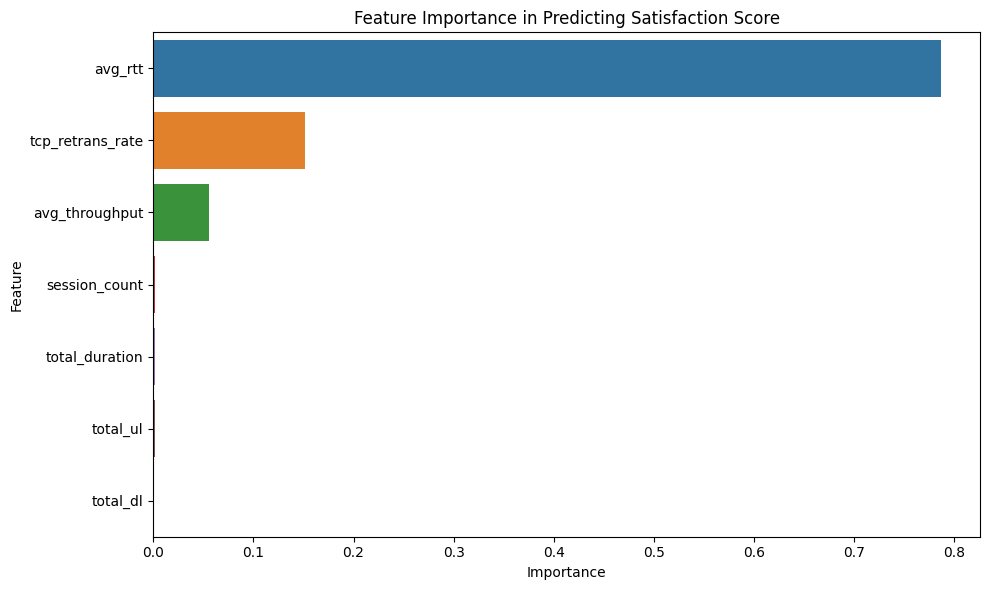

In [21]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Predicting Satisfaction Score')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

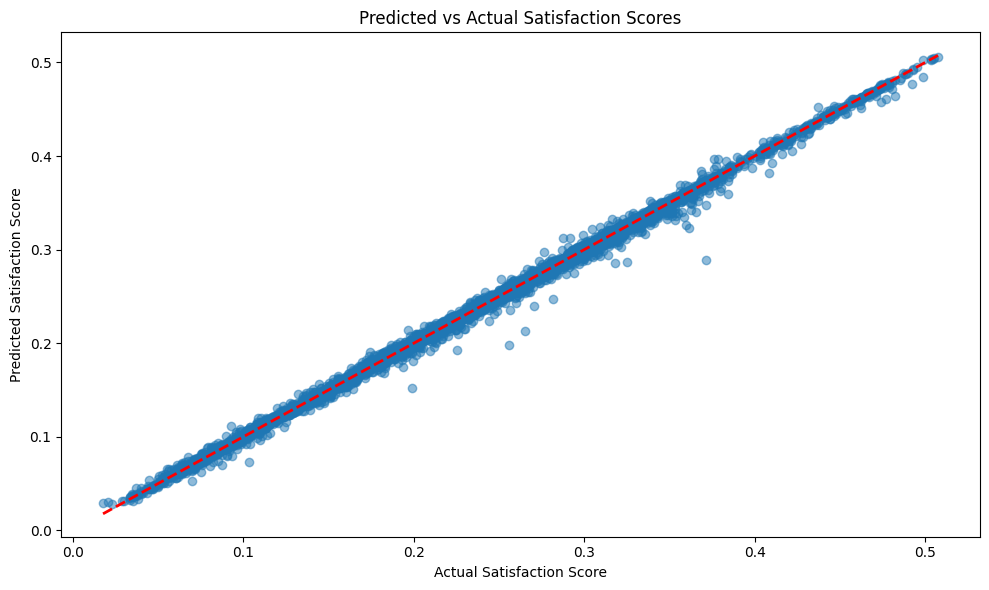

In [23]:
# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Satisfaction Score')
plt.ylabel('Predicted Satisfaction Score')
plt.title('Predicted vs Actual Satisfaction Scores')
plt.tight_layout()
plt.show()

### Clustering

In [22]:
# Run k-means clustering on engagement and experience scores
clusters = analyzer.cluster_users(engagement_scores, experience_scores)
# Add cluster assignments to results dataframe
results_df['cluster'] = clusters

c:\Users\Kalea\Desktop\week-2\env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


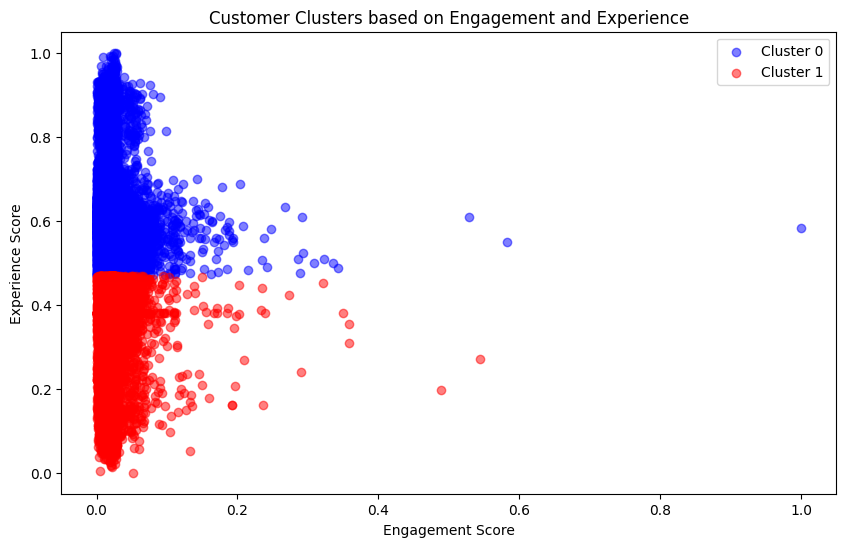

In [23]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(results_df[results_df['cluster'] == 0]['engagement_score'], 
           results_df[results_df['cluster'] == 0]['experience_score'], 
           c='blue', label='Cluster 0', alpha=0.5)
plt.scatter(results_df[results_df['cluster'] == 1]['engagement_score'], 
           results_df[results_df['cluster'] == 1]['experience_score'], 
           c='red', label='Cluster 1', alpha=0.5)
plt.xlabel('Engagement Score')
plt.ylabel('Experience Score')
plt.title('Customer Clusters based on Engagement and Experience')
plt.legend()
plt.show()

In [24]:
# Print cluster sizes
print("\nCluster Sizes:")
print(results_df['cluster'].value_counts())

# Calculate cluster statistics
cluster_stats = results_df.groupby('cluster')[['engagement_score', 'experience_score', 'satisfaction_score']].agg([
    'mean', 'std', 'count'
]).round(4)


Cluster Sizes:
0    70482
1    36374
Name: cluster, dtype: int64


### cluster anlysis

In [25]:
print("\nCluster Statistics:")
print(cluster_stats)


Cluster Statistics:
        engagement_score                experience_score                 \
                    mean     std  count             mean     std  count   
cluster                                                                   
0                 0.0195  0.0115  70482           0.6009  0.0650  70482   
1                 0.0207  0.0109  36374           0.3361  0.0916  36374   

        satisfaction_score                 
                      mean     std  count  
cluster                                    
0                   0.3102  0.0331  70482  
1                   0.1784  0.0460  36374  


In [26]:
# Create a summary table for easier interpretation
summary_df = pd.DataFrame({
    'Cluster': ['Cluster 0', 'Cluster 1'],
    'Size': results_df['cluster'].value_counts().sort_index(),
    'Avg Satisfaction': results_df.groupby('cluster')['satisfaction_score'].mean(),
    'Avg Experience': results_df.groupby('cluster')['experience_score'].mean(),
    'Avg Engagement': results_df.groupby('cluster')['engagement_score'].mean()
})
print("\nCluster Summary:")
print(summary_df.round(4))


Cluster Summary:
     Cluster   Size  Avg Satisfaction  Avg Experience  Avg Engagement
0  Cluster 0  70482            0.3102          0.6009          0.0195
1  Cluster 1  36374            0.1784          0.3361          0.0207


### cluster visualization

In [27]:
# Visualize the average scores by cluster
plt.figure(figsize=(10, 6))
cluster_means = results_df.groupby('cluster')[
    ['satisfaction_score', 'experience_score', 'engagement_score']
].mean()

<Figure size 1000x600 with 0 Axes>

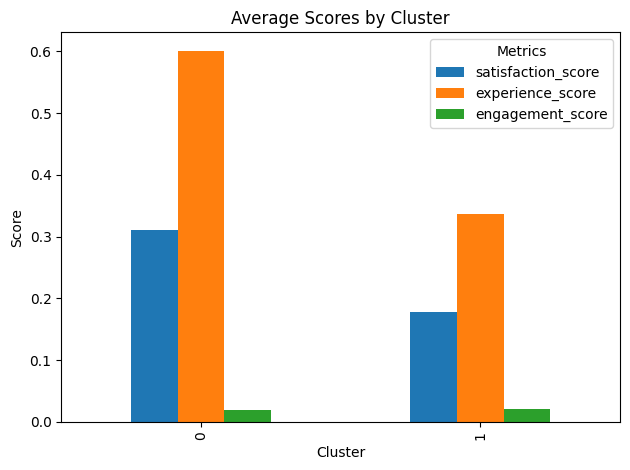

In [28]:
cluster_means.plot(kind='bar')
plt.title('Average Scores by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Score')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

### Data export to database

In [29]:
# Prepare final dataframe for export
final_export_df = results_df[['msisdn', 'engagement_score', 'experience_score', 'satisfaction_score', 'cluster']]
# Rename columns to be more database-friendly
final_export_df = final_export_df.rename(columns={
    'msisdn': 'user_id',
})

In [30]:
export_to_db(final_export_df, 'user_satisfaction_scores')

Data successfully exported to table: user_satisfaction_scores
Error exporting to PostgreSQL: 'OptionEngine' object has no attribute 'execute'


False

In [31]:
#  verify using load_data function
verification_query = "SELECT * FROM user_satisfaction_scores LIMIT 5;"
verification_df = load_data(verification_query)

print("\nVerification of exported data:")
print(verification_df)

Connected to the database
Data loaded successfully
Database connection closed

Verification of exported data:
        user_id  engagement_score  experience_score  satisfaction_score  \
0  3.360100e+10          0.019038          0.593688            0.306363   
1  3.360100e+10          0.025250          0.631856            0.328553   
2  3.360100e+10          0.019948          0.380056            0.200002   
3  3.360101e+10          0.025826          0.498676            0.262251   
4  3.360101e+10          0.010188          0.545511            0.277850   

   cluster  
0        0  
1        0  
2        1  
3        0  
4        0  


c:\Users\Kalea\Desktop\week-2\notebooks\../scripts\load_data.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(query, conn)
